# Analyzing CIA Factbook Using SQLite and Python
<br/><br/>
### Project Objective:

In this project, we'll work with data from the CIA World Factbook, a compendium of statistics about all of the countries on Earth. The Factbook contains demographic information.

### Importing required libaries for this project :

In [5]:
# importing sqlite and pandas, connecting sqlite database
import pandas as pd
import sqlite3 as sql
# using sqlite default quering will result in nested tuples
conn = sql.connect("factbook.db")
query = "SELECT * FROM sqlite_master WHERE type IN ('table','view')"
cursor = conn.cursor()
cursor.execute(query).fetchall()

[('table',
  'sqlite_sequence',
  'sqlite_sequence',
  3,
  'CREATE TABLE sqlite_sequence(name,seq)'),
 ('table',
  'facts',
  'facts',
  47,
  'CREATE TABLE "facts" ("id" INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL, "code" varchar(255) NOT NULL, "name" varchar(255) NOT NULL, "area" integer, "area_land" integer, "area_water" integer, "population" integer, "population_growth" float, "birth_rate" float, "death_rate" float, "migration_rate" float)'),
 ('table',
  'cities',
  'cities',
  2,
  'CREATE TABLE cities (\n        id integer primary key,\n        name text,\n        population integer,\n        capital bool,\n        facts_id text,\n        foreign key(facts_id) references facts(id)\n    )')]

In [6]:
# using pandas to run sqlite queries and displaying database tables
query = "SELECT * FROM sqlite_master WHERE type IN ('table','view')"
pd.read_sql_query(query, conn)

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,facts,facts,47,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY..."
2,table,cities,cities,2,CREATE TABLE cities (\n id integer prim...


In [7]:
#  exploring the table facts by displaying table columns and data types
q = "PRAGMA table_info(facts)"
pd.read_sql(q, conn)

,cid,name,type,notnull,dflt_value,pk
0,0,id,INTEGER,1,None,1
1,1,code,varchar(255),1,None,0
2,2,name,varchar(255),1,None,0
3,3,area,integer,0,None,0
4,4,area_land,integer,0,None,0
5,5,area_water,integer,0,None,0
6,6,population,integer,0,None,0
7,7,population_growth,float,0,None,0
8,8,birth_rate,float,0,None,0
9,9,death_rate,float,0,None,0


In [8]:
# continue exploring the table by displaying the first 5 rows
q = "SELECT * FROM facts LIMIT 5"
pd.read_sql(q, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51
1,2,al,Albania,28748,27398,1350,3029278,0.30,12.92,6.58,3.30
2,3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92
3,4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.00
4,5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46


In [9]:
# continue exploring the table by displaying the max and min values for population and population_growth
q = "SELECT MIN(population), MAX(population), MIN(population_growth), MAX(population_growth) FROM facts"
pd.read_sql(q, conn)

,MIN(population),MAX(population),MIN(population_growth),MAX(population_growth)
0,0,7256490011,0.0,4.02


A few things stick out from the summary statistics in the last screen:

* there's a country with a population of 0
* there's a country with a population of `7256490011` (or more than 7.2 billion people)
Let's zoom in on just these countries.

In [10]:
# continue exploring the table by displaying the row that contain the min population
q = '''SELECT * FROM facts WHERE population = (SELECT MIN(population) FROM facts)'''
pd.read_sql(q, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,250,ay,Antarctica,None,280000,None,0,None,None,None,None


In [11]:
# continue exploring the table by displaying the row that contain the max population
q =  '''SELECT * FROM facts WHERE population = (SELECT MAX(population) FROM facts)'''
pd.read_sql(q, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,261,xx,World,None,None,None,7256490011,1.08,18.6,7.8,None


Let's generate histograms for the rest of the countries in the table, ignoring these 2 rows and showing `population`, `population_growth`, `death_rate` & `migration_rate` columns.

E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3267: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002075C7F6D68>,
      dtype=object)

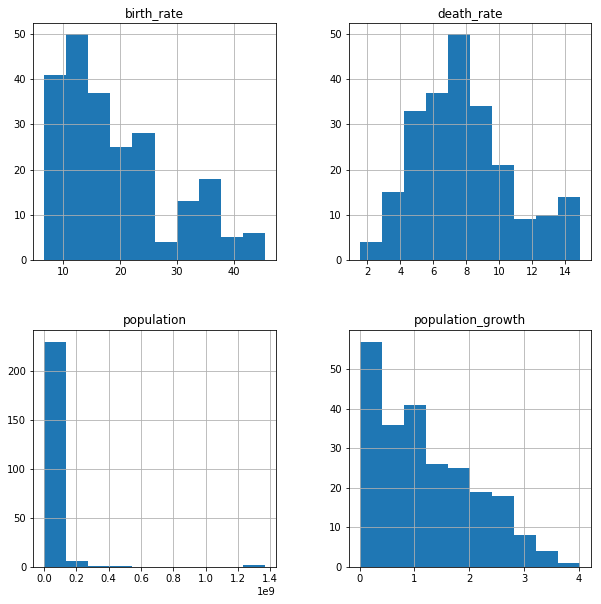

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
q = '''SELECT population, population_growth, birth_rate, death_rate 
FROM facts 
WHERE population != (SELECT MIN(population) FROM facts) 
AND population != (SELECT MAX(population) FROM facts)'''
pd.read_sql(q, conn).hist(ax=ax)

We can create a version of facts table where only countries selected without including the world, regions and oceans. Lets start create this table

In [13]:
# displaying the bottom 10 rows
q = '''SELECT * 
FROM facts 
ORDER BY id desc 
LIMIT 10'''
pd.read_sql(q, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,261,xx,World,NaN,NaN,NaN,7.256490e+09,1.08,18.60,7.80,NaN
1,260,oo,Southern Ocean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,259,zn,Pacific Ocean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,258,xo,Indian Ocean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,257,zh,Atlantic Ocean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,256,xq,Arctic Ocean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,255,wi,Western Sahara,266000.0,266000.0,0.0,5.708660e+05,2.82,30.24,8.34,NaN
7,254,we,West Bank,5860.0,5640.0,220.0,2.785366e+06,1.95,22.99,3.50,0.0
8,253,pg,Spratly Islands,5.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN
9,252,pf,Paracel Islands,7.0,7.0,0.0,NaN,NaN,NaN,NaN,NaN


We can notice that the `area` values for our targeted rows equal to zero. Lets investigate this further. 

In [14]:
q = '''SELECT * 
FROM facts 
WHERE area is null'''
pd.read_sql(q, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,35,cd,Chad,None,1259200.0,24800.0,1.163146e+07,1.89,36.60,14.28,3.45
1,128,ng,Niger,None,1266700.0,300.0,1.804573e+07,3.25,45.45,12.42,0.56
2,210,fs,French Southern and Antarctic Lands,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,212,tb,Saint Barthelemy,None,NaN,NaN,7.237000e+03,NaN,NaN,NaN,NaN
4,249,um,United States Pacific Island Wildlife Refuges,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,250,ay,Antarctica,None,280000.0,NaN,0.000000e+00,NaN,NaN,NaN,NaN
6,256,xq,Arctic Ocean,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,257,zh,Atlantic Ocean,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,258,xo,Indian Ocean,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,259,zn,Pacific Ocean,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN


While exploring the previous table where is the `area` is equal to zero, we encountered another problem in our table. If we looked carefully, we will notice that the first two rows, area's values equal zero, however there are credible values in the `area_land` and `area_water` values. To avoid omitting important information in our analysis, we will update these two area's values by adding the values of the `area_land` and `area_water` together. 

In [15]:
# updating the area values for Chad and Niger
q = '''UPDATE facts 
SET area = area_land + area_water 
WHERE id in (35, 128)'''
conn.execute(q)

In [16]:
# confirming the new values are in place 
q = '''SELECT * FROM facts WHERE id in (35, 128)'''
pd.read_sql(q, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,35,cd,Chad,1284000,1259200,24800,11631456,1.89,36.60,14.28,3.45
1,128,ng,Niger,1267000,1266700,300,18045729,3.25,45.45,12.42,0.56


Now let's take a look at the table including countries only

In [17]:
# showing the table with countries only
q = '''SELECT * 
FROM facts 
WHERE area != 0'''
pd.read_sql(q, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,1,af,Afghanistan,652230,652230.0,0.0,32564342.0,2.32,38.57,13.89,1.51
1,2,al,Albania,28748,27398.0,1350.0,3029278.0,0.30,12.92,6.58,3.30
2,3,ag,Algeria,2381741,2381741.0,0.0,39542166.0,1.84,23.67,4.31,0.92
3,4,an,Andorra,468,468.0,0.0,85580.0,0.12,8.13,6.96,0.00
4,5,ao,Angola,1246700,1246700.0,0.0,19625353.0,2.78,38.78,11.49,0.46
5,6,ac,Antigua and Barbuda,442,442.0,0.0,92436.0,1.24,15.85,5.69,2.21
6,7,ar,Argentina,2780400,2736690.0,43710.0,43431886.0,0.93,16.64,7.33,0.00
7,8,am,Armenia,29743,28203.0,1540.0,3056382.0,0.15,13.61,9.34,5.80
8,9,as,Australia,7741220,7682300.0,58920.0,22751014.0,1.07,12.15,7.14,5.65
9,10,au,Austria,83871,82445.0,1426.0,8665550.0,0.55,9.41,9.42,5.56


Now lets create a view from this table.

In [18]:
# create a view from the above table
q = '''CREATE view facts_countries AS 
SELECT * FROM facts 
WHERE area !=0'''
conn.execute(q)

In [19]:
# confirming the creation of the new view of the previous table
q = "SELECT type, name FROM sqlite_master WHERE type IN ('table','view')"
pd.read_sql_query(q, conn)

,type,name
0,table,sqlite_sequence
1,table,facts
2,table,cities
3,view,facts_countries


## Now let's try to answer some questions

### 1. What are the most populous countries ?

In [20]:
q = '''SELECT name, population 
FROM facts_countries 
ORDER BY 2 DESC 
LIMIT 10'''
pd.read_sql(q, conn)

,name,population
0,China,1367485388
1,India,1251695584
2,European Union,513949445
3,United States,321368864
4,Indonesia,255993674
5,Brazil,204259812
6,Pakistan,199085847
7,Nigeria,181562056
8,Bangladesh,168957745
9,Russia,142423773


Text(0.5, 1.0, 'Most Populous Countries in The World')

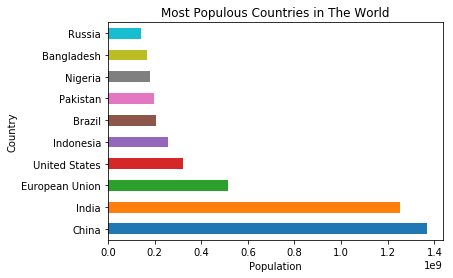

In [21]:
# illustrate the list in horizental bar chart
q = '''SELECT name, population 
FROM facts_countries 
ORDER BY 2 DESC 
LIMIT 10'''
pd.read_sql(q, conn).plot.barh(y='population', x='name', legend=False)
plt.ylabel('Country')
plt.xlabel('Population')
plt.title('Most Populous Countries in The World')

## 2. What are the most populous cities in the world and in which country they are in ?

In [22]:
q = '''SELECT c.name city, c.population, fc.name country 
FROM cities c
INNER JOIN facts_countries fc ON fc.id = c.facts_id 
ORDER BY 2 DESC 
LIMIT 10
'''
pd.read_sql(q, conn)

,city,population,country
0,Tokyo,37217000,Japan
1,New Delhi,22654000,India
2,Mexico City,20446000,Mexico
3,New York-Newark,20352000,United States
4,Shanghai,20208000,China
5,Sao Paulo,19924000,Brazil
6,Mumbai,19744000,India
7,Beijing,15594000,China
8,Dhaka,15391000,Bangladesh
9,Marseille-Aix-en-Provence,14890100,France


Text(0.5, 1.0, 'Most Populous Cities in The World')

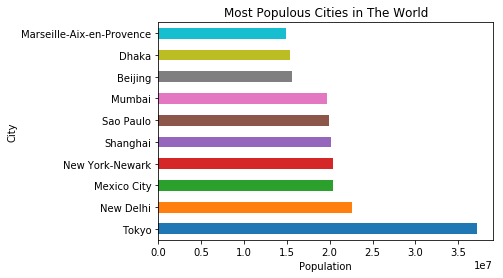

In [23]:
# illustrate the list in horizental bar chart
q = '''SELECT c.name city, c.population, fc.name country 
FROM cities c
INNER JOIN facts_countries fc ON fc.id = c.facts_id 
ORDER BY 2 DESC 
LIMIT 10
'''
pd.read_sql(q, conn).plot.barh(y='population', x='city', legend=False)
plt.ylabel('City')
plt.xlabel('Population')
plt.title('Most Populous Cities in The World')

## 3. What are the most populous capital cities in the world ?

In [24]:
q = '''SELECT c.name capital_city, c.population, fc.name country 
FROM cities c 
INNER JOIN facts_countries fc ON fc.id=c.facts_id 
WHERE capital = 1 
ORDER BY 2 DESC
LIMIT 10'''
pd.read_sql(q, conn)

,capital_city,population,country
0,Tokyo,37217000,Japan
1,New Delhi,22654000,India
2,Mexico City,20446000,Mexico
3,Beijing,15594000,China
4,Dhaka,15391000,Bangladesh
5,Buenos Aires,13528000,Argentina
6,Manila,11862000,Philippines
7,Moscow,11621000,Russia
8,Cairo,11169000,Egypt
9,Jakarta,9769000,Indonesia


Text(0.5, 1.0, 'Most Populous Capital Cities in The World')

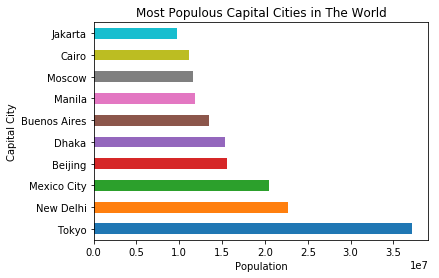

In [25]:
# illustrate the list in horizental bar chart
q = '''SELECT c.name capital_city, c.population, fc.name country 
FROM cities c 
INNER JOIN facts_countries fc ON fc.id=c.facts_id 
WHERE capital = 1 
ORDER BY 2 DESC
LIMIT 10'''
pd.read_sql(q, conn).plot.barh(y='population', x='capital_city', legend=False)
plt.ylabel('Capital City')
plt.xlabel('Population')
plt.title('Most Populous Capital Cities in The World')

## What are the countries where the urban center (city) population is more than half of the country's total population.

In [26]:
q = '''SELECT fc.name country, urban_pop, fc.population total_pop, ROUND((CAST(urban_pop AS FLOAT)/CAST(fc.population AS FLOAT)),2) urban_pct 
FROM facts_countries fc 
INNER JOIN (SELECT facts_id, SUM(population) urban_pop FROM cities GROUP BY 1) c ON c.facts_id=fc.id 
WHERE urban_pct > 0.5 
AND urban_pct < 1
ORDER BY 4 desc'''
pd.read_sql(q, conn)

,country,urban_pop,total_pop,urban_pct
0,Saint Pierre and Miquelon,5000,5657,0.88
1,Kuwait,2406000,2788534,0.86
2,"Bahamas, The",254000,324597,0.78
3,Puerto Rico,2475000,3598357,0.69
4,United Arab Emirates,3903000,5779760,0.68
5,Israel,5226000,8049314,0.65
6,Iceland,206000,331918,0.62
7,Australia,13789000,22751014,0.61
8,Falkland Islands (Islas Malvinas),2000,3361,0.60
9,Djibouti,496000,828324,0.60
